In [1]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.28.0'

In [2]:
import qiskit

qiskit.version.get_version_info()

'1.2.0'

In [3]:
# Built-in modules
import math
import numpy as np

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, PhaseEstimation
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

#### Chosing Backend

In [4]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()
backend.name

'aer_simulator'

In [5]:
def order_finding_classical(a, N):
        if (a < 1) or (a >= N) or (N <= 1):
            raise ValueError("The integer a must be in the range 1 <= a <= N-1 and N must be greater than 1.")
        if math.gcd(a, N) != 1:
            raise ValueError("The integer a must be coprime with N.")
        
        def mod_exp(base, exp, mod):
            result = 1
            while exp > 0:
                if exp % 2 == 1:
                    result = (result * base) % mod
                base = (base * base) % mod
                exp //= 2
            return result
        
        r = 1
        while mod_exp(a, r, N) != 1:
            r += 1
        return r

In [ ]:
def c_amod15(a):
    """
    Controlled multiplication by a mod 15.
    This is hard-coded for simplicity.
    """
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must not have common factors with 15")
    U = QuantumCircuit(4)
    if a in [2, 13]:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    if a in [7, 8]:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    if a in [4, 11]:
        U.swap(1, 3)
        U.swap(0, 2)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f"{a} mod 15"
    c_U = U.control()
    return c_U

In [61]:
 def c_amod15(a):
        """
        Controlled multiplication by a mod 15.
        This is hard-coded for simplicity.
        """
        if a not in [2, 4, 7, 8, 11, 13]:
            raise ValueError("'a' must not have common factors with 15")
        U = QuantumCircuit(4)
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
        U = U.to_gate()
        U.name = f"{a} mod 15"
        c_U = U.control()
        return c_U

In [93]:
def order_finding_quantum(a,N, epsilon=0.4,shots=1000):
    num_qubits = math.ceil(math.log2(N))
    epsilon=0.4

    def c_amod15(a):
        """
        Controlled multiplication by a mod 15.
        This is hard-coded for simplicity.
        """
        if a not in [2, 4, 7, 8, 11, 13]:
            raise ValueError("'a' must not have common factors with 15")
        U = QuantumCircuit(4)
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
        U = U.to_gate()
        U.name = f"{a} mod 15"
        c_U = U.control()
        return c_U

    # Create QuantumCircuit
    num_evaluation_bits = 2*num_qubits + 1 + math.ceil(math.log2(2+(1/(2*epsilon))))
    qbits = QuantumRegister(num_qubits + num_evaluation_bits +1, name='qbits')
    cbits=ClassicalRegister(num_evaluation_bits,name='cbits')
    qc = QuantumCircuit(qbits,cbits,name='qc')
    qc.compose(PhaseEstimation(num_evaluation_bits, unitary=c_amod15(a)), inplace=True)
    qc.measure(range(num_evaluation_bits),cbits)

    target = backend.target

    pm = generate_preset_pass_manager(target=target, optimization_level=1)

    circuit_isa = pm.run(qc)
    # circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 1000
    result = sampler.run([circuit_isa]).result()
    dist = result[0].data.cbits.get_counts()
    return dist

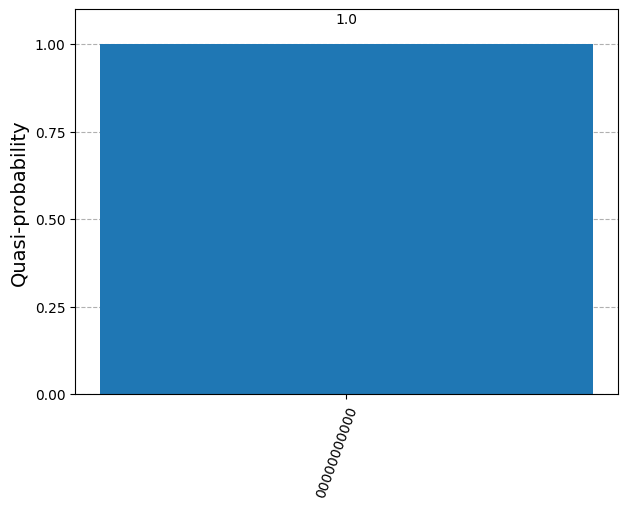

In [94]:
qu = order_finding_quantum(7,15)
plot_distribution(qu)

In [ ]:
def Shor(N):
    # Check if $N$ is even
    factors={}
    while N%2==0:
        if 2 not in factors:
            factors[2]=0
        factors[2]+=1
        N=N//2

    if N!=1:
        log2n=math.log2(N)

        for b in range(2,math.floor(log2n)+1):
            x=log2n/b
            
            u_1=math.floor(2**x)
            u_2=math.ceil(2**x)
            if u_1**b==N:
                factors[u_1]=b
                N=N//(u_1**b)
                break
            elif u_2**b==N:
                factors[u_2]=b
                N=N//(u_2**b)
                break
            else:
                continue

    if N!=1:
        while N!=1:
            a = np.random.randint(1,N)

            if (math.gcd(a,N))!=1:
                p = math.gcd(a,N)
                q = N//p
                if p not in factors:
                    factors[p]=0
                    N=N//p
                factors[p]+=1
                if q not in factors:
                    factors[q]=0
                    N=N//q
                factors[q]+=1
            else:
                if (N==21):
                    r = order_finding_classical(a,N)
                # else:
                #     r=order_finding_quantum(a,N)
                if r%2==0:
                    p = math.gcd(a**int(r/2)+1,N)
                    q = math.gcd(a**int(r/2)-1,N)
                    if p not in factors:
                        factors[p]=0
                        N=N//p
                    factors[p]+=1
                    if q not in factors:
                        factors[q]=0
                    N=N//q
                    factors[q]+=1
    return factors

In [7]:
N=3**7*2**5
factors = Shor(N)
print(factors)

{2: 5, 3: 7}
